In [1]:
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Parameters
fs = 1e6       # Sample rate (1 MHz)
fc = 100e3        # Carrier freq (100 kHz)
fm = 1e3          # Message freq (1 kHz)
t = np.arange(0, 0.01, 1/fs)
message = np.cos(2 * np.pi * fm * t)
message = np.cos(2 * np.pi * fm * t) + 0.5 * np.cos(2 * np.pi * 2.5 * fm * t)

# 1. DSB-SC
dsb_sc = message * np.cos(2 * np.pi * fc * t)

# 2. SSB (Upper Sideband)
m_hilbert = hilbert(message)
ssb_usb = np.real(m_hilbert * np.exp(1j * 2 * np.pi * fc * t))

# 3. FM
kf = 50000         # Frequency deviation
integral_m = np.cumsum(message) / fs
fm_signal = np.cos(2 * np.pi * fc * t + 2 * np.pi * kf * integral_m)

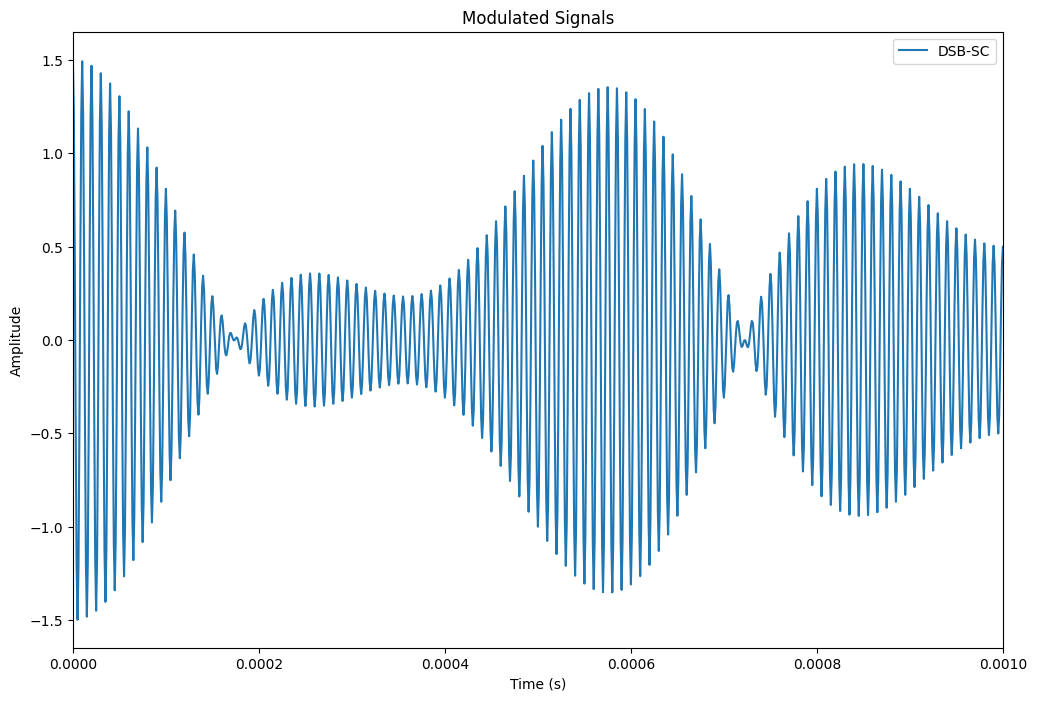

In [2]:
plt.figure(figsize=(12, 8))
plt.plot(t, dsb_sc, label='DSB-SC')
#plt.plot(t, ssb_usb, label='SSB USB')
#plt.plot(t, fm_signal, label='FM')
plt.xlim(0, 0.001)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Modulated Signals')
plt.show()

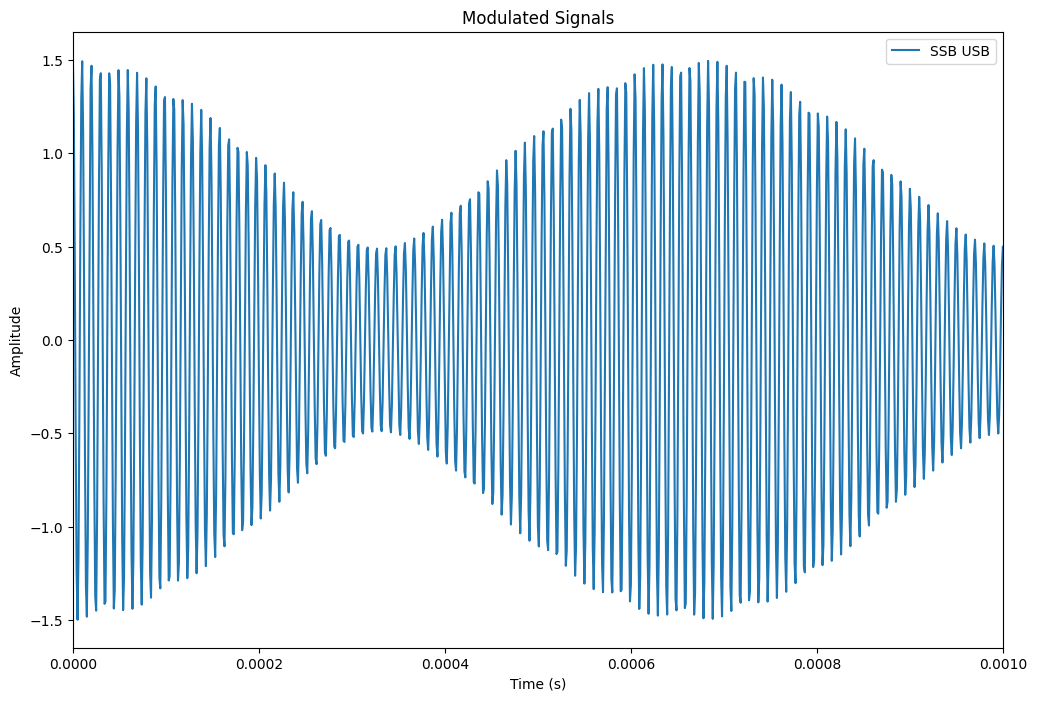

In [3]:
plt.figure(figsize=(12, 8))
plt.plot(t, ssb_usb, label='SSB USB')
plt.xlim(0, 0.001)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Modulated Signals')
plt.show()

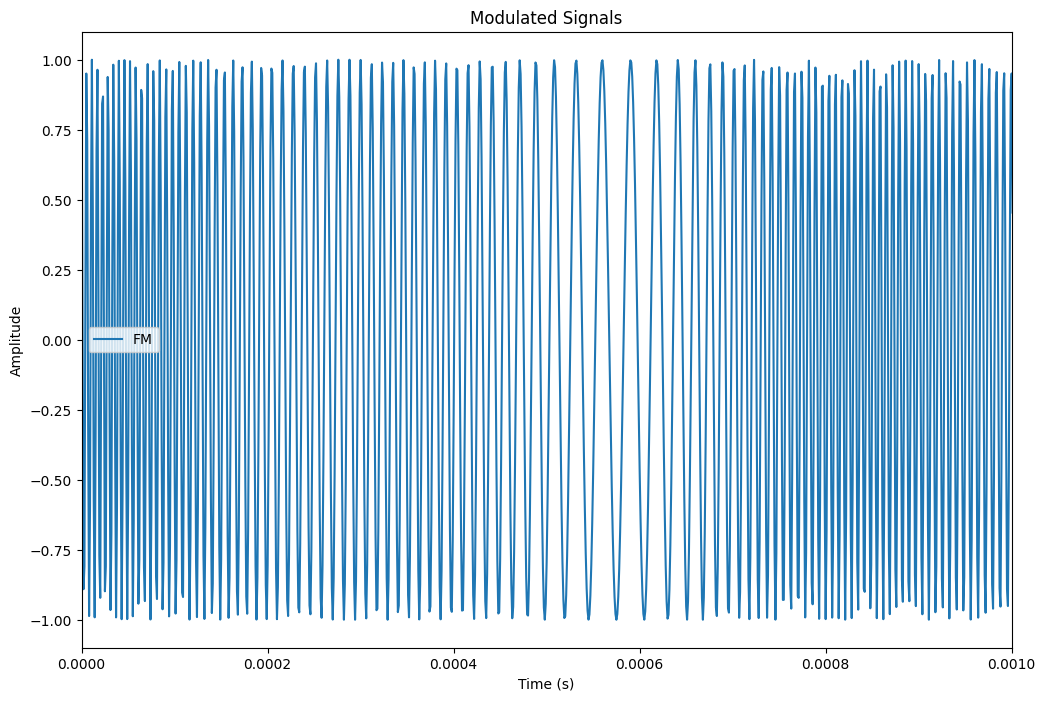

In [4]:
plt.figure(figsize=(12, 8))
plt.plot(t, fm_signal, label='FM')
plt.xlim(0, 0.001)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Modulated Signals')
plt.show()

DSB-SC Envelope Variance: 0.6590630531723948
SSB USB Envelope Variance: 0.10509281299328126
FM Envelope Variance: 6.422067325597681e-33


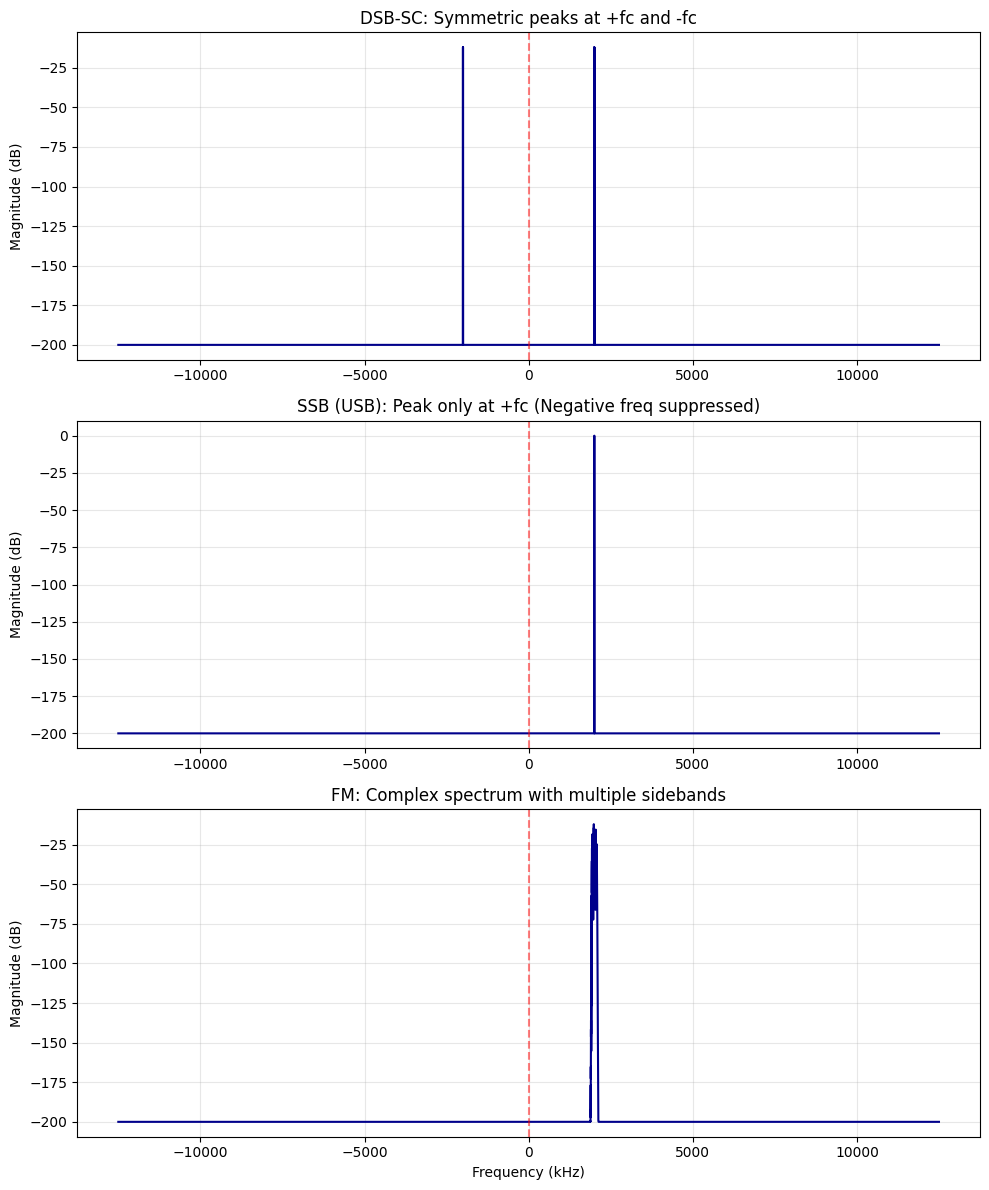

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# Parameters
fs = 25e6       # Sample rate (1 MHz)
fc = 2e6        # Carrier freq (100 kHz)
fm = 1e3          # Message freq (1 kHz)
t = np.arange(0, 0.002, 1/fs) # 2ms duration
message = np.cos(2 * np.pi * fm * t)
# Use two frequencies to see envelope fluctuations
message = np.cos(2 * np.pi * fm * t) + 0.5 * np.cos(2 * np.pi * 2.5 * fm * t)
# Signal Generation
# DSB-SC (Real)
dsb_sc = message * np.cos(2 * np.pi * fc * t)

# SSB (Complex Baseband representation is common for Pluto)
# Here we use the analytic version to show asymmetry
ssb_usb = hilbert(message) * np.exp(1j * 2 * np.pi * fc * t)

# FM (Complex Exponential form)
kf = 50000
integral_m = np.cumsum(message) / fs
fm_signal = np.exp(1j * (2 * np.pi * fc * t + 2 * np.pi * kf * integral_m))
def check_envelope(signal):
    envelope = np.abs(signal)
    # Normalized variance: Var / Mean^2
    variance = np.var(envelope) / (np.mean(envelope)**2)
    return variance
print("DSB-SC Envelope Variance:", check_envelope(dsb_sc))
print("SSB USB Envelope Variance:", check_envelope(ssb_usb))
print("FM Envelope Variance:", check_envelope(fm_signal))
def plot_complex_spectrum(signal, title, pos):
    plt.subplot(3, 1, pos)
    
    # Compute FFT and shift
    n = len(signal)
    fft_val = np.fft.fftshift(np.fft.fft(signal)) / n
    freqs = np.fft.fftshift(np.fft.fftfreq(n, 1/fs))
    
    # Convert to dB for visibility
    psd = 20 * np.log10(np.abs(fft_val) + 1e-10) 
    
    plt.plot(freqs / 1e3, psd, color='darkblue')
    plt.title(title)
    plt.ylabel('Magnitude (dB)')
    plt.grid(True, alpha=0.3)
    plt.axvline(0, color='red', linestyle='--', alpha=0.5) # Zero frequency marker

plt.figure(figsize=(10, 12))
plot_complex_spectrum(dsb_sc, "DSB-SC: Symmetric peaks at +fc and -fc", 1)
plot_complex_spectrum(ssb_usb, "SSB (USB): Peak only at +fc (Negative freq suppressed)", 2)
plot_complex_spectrum(fm_signal, "FM: Complex spectrum with multiple sidebands", 3)
plt.xlabel('Frequency (kHz)')
plt.tight_layout()
plt.show()

In [6]:
def add_awgn_noise(signal, target_snr_db):
    # 1. Calculate signal power 
    # Power = Mean of the squared absolute values
    sig_power = np.mean(np.abs(signal)**2)
    sig_power_db = 10 * np.log10(sig_power)
    
    # 2. Calculate required noise power in dB
    noise_power_db = sig_power_db - target_snr_db
    noise_power_linear = 10**(noise_power_db / 10)
    
    # 3. Generate white noise
    # For RF/Complex signals, noise is usually complex
    # For real-only simulation, use: np.random.normal(0, np.sqrt(noise_power_linear), len(signal))
    noise = np.random.normal(0, np.sqrt(noise_power_linear), len(signal))
    
    return signal + noise

# Usage:
snr_to_test = 20 # 10dB is a moderate noise level
noisy_dsb_sc = add_awgn_noise(dsb_sc, snr_to_test)
noisy_fm = add_awgn_noise(fm_signal, snr_to_test)
noisy_ssb = add_awgn_noise(ssb_usb, snr_to_test)

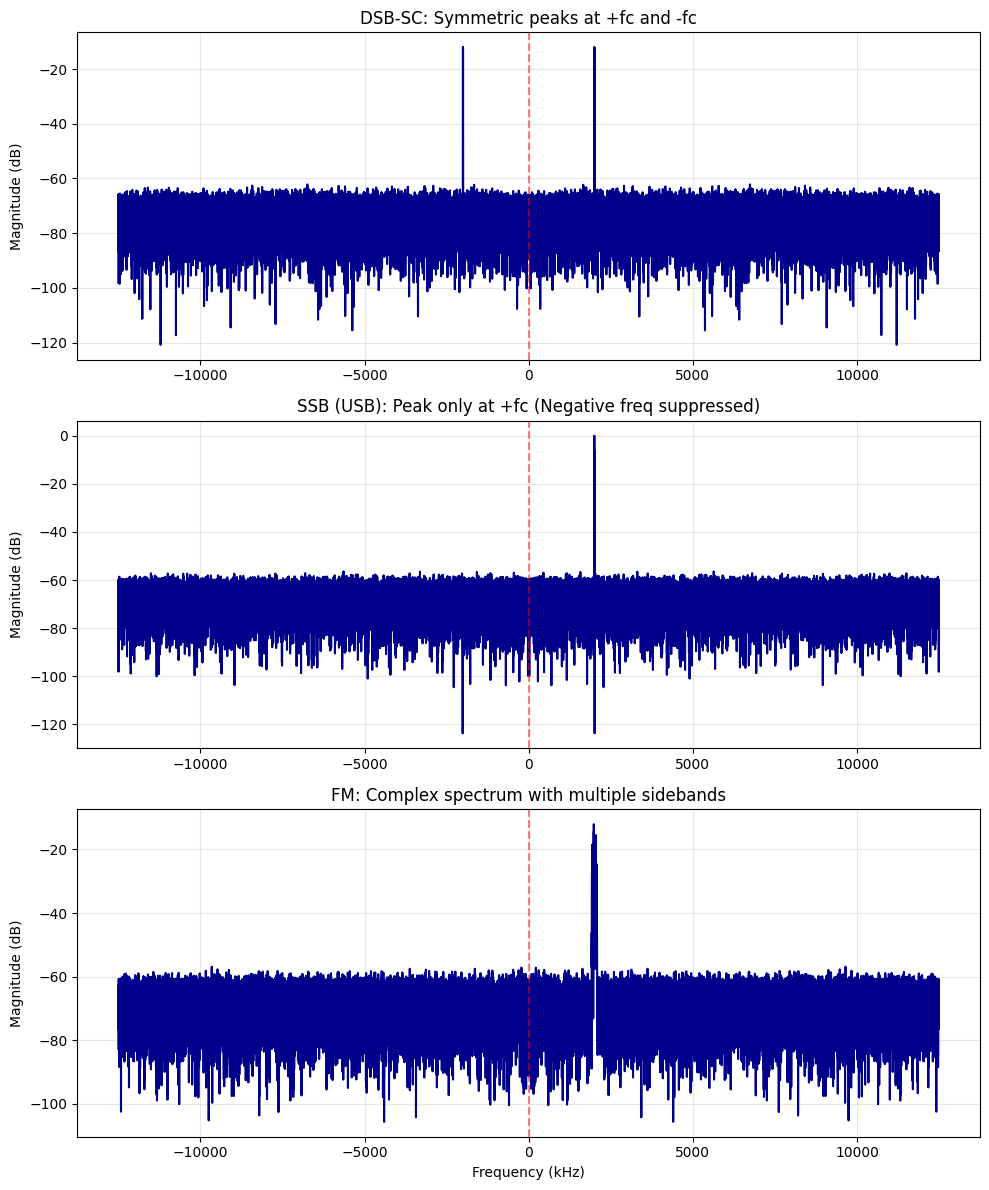

In [7]:
plt.figure(figsize=(10, 12))
plot_complex_spectrum(noisy_dsb_sc, "DSB-SC: Symmetric peaks at +fc and -fc", 1)
plot_complex_spectrum(noisy_ssb, "SSB (USB): Peak only at +fc (Negative freq suppressed)", 2)
plot_complex_spectrum(noisy_fm, "FM: Complex spectrum with multiple sidebands", 3)
plt.xlabel('Frequency (kHz)')
plt.tight_layout()
plt.show()

In [8]:
no_message = np.zeros(len(t))
noisy_no_message = add_awgn_noise(no_message, snr_to_test)


/var/folders/vw/n2915_zd18bdk7zj8tsnq6n40000gn/T/ipykernel_78277/4116929285.py:5: RuntimeWarning: divide by zero encountered in log10
  sig_power_db = 10 * np.log10(sig_power)


In [9]:
from scipy.fftpack import fftshift,fft,fftfreq
from scipy.signal import hilbert, find_peaks, peak_widths

samples=noisy_fm
lo_freq=0
n = len(samples)
spec = fftshift(fft(samples))
psd_db = 20 * np.log10(np.abs(spec) / n + 1e-12)
freq_axis = fftshift(fftfreq(n, 1/fs))
    
    # 2. Peak Detection (Find the strongest signal in the buffer)
    # distance=n//10 ensures we don't pick multiple peaks for one wide signal
peaks, props = find_peaks(psd_db, height=-65, distance=n//10)
    
if len(peaks) == 0:
    print("No signal detected")
else:
    print("signal found")
    best_peak = peaks[np.argmax(props['peak_heights'])]
    print(f"Strongest peak at frequency: {freq_axis[best_peak]/1e3} kHz with magnitude {props['peak_heights'].max():.2f} dB")
    # 3. Parameter Estimation [cite: 28, 29, 32]
    fc_hz = lo_freq + freq_axis[best_peak]
    print(f"Estimated Carrier Frequency: {fc_hz/1e3} kHz")
    snr_db = psd_db[best_peak] - np.median(psd_db)
    print("median",np.mean(psd_db))
    print(f"Estimated SNR: {snr_db:.2f} dB")
    noise_floor = np.median(psd_db)
    threshold = noise_floor + 20  # Look for signal 10dB above noise

    # 2. Find all indices where signal is above threshold
    above_indices = np.where(psd_db > threshold)[0]

    if len(above_indices) > 0:
        # 3. Focus ONLY on the group of indices around your best_peak
        # This prevents counting other signals or noise spikes elsewhere
        peak_idx = best_peak
        
        # Find the start and end of the continuous block containing the peak
        # We look for the first index below threshold to the left and right
        lower_bound = above_indices[above_indices < peak_idx]
        upper_bound = above_indices[above_indices > peak_idx]
        
        start_idx = lower_bound[-1] if len(lower_bound) > 0 else above_indices[0]
        end_idx = upper_bound[0] if len(upper_bound) > 0 else above_indices[-1]
        
        # 4. Calculate Bandwidth
        bw_hz = (end_idx - start_idx) * (fs / n)
        print(f"Calculated BW: {bw_hz/1e3:.2f} kHz")
    analytic = samples
    envelope = np.abs(analytic)
    # Normalized variance: High for AM, Low for FM [cite: 20]
    env_var = np.var(envelope) / (np.mean(envelope)**2)
    
    # 5. Spectral Symmetry (SSB vs DSB-SC) [cite: 11, 12, 20]
    halfway = n // 2
    lsb_power = np.sum(np.abs(spec[:halfway])**2)
    usb_power = np.sum(np.abs(spec[halfway:])**2)
    sideband_ratio = max(lsb_power, usb_power) / (min(lsb_power, usb_power) + 1e-9)
    # 6. Final Decision Logic [cite: 31]
    if env_var < 0.0001: # Threshold for constant envelope
        mod_type = "FM"
        confidence = min(0.99, snr_db / 40)
    elif sideband_ratio > 8: # Significant power in only one sideband
        mod_type = "SSB"
        confidence = min(0.95, sideband_ratio / 20)
    else:
        mod_type = "DSB-SC"
        confidence = 0.85 # Default for symmetric AM
    print(f"Detected Modulation: {mod_type} with confidence {confidence*100:.1f}%")

signal found
Strongest peak at frequency: 1985.0 kHz with magnitude -12.06 dB
Estimated Carrier Frequency: 1985.0 kHz
median -69.21595226863909
Estimated SNR: 56.43 dB
Calculated BW: 1.00 kHz
Detected Modulation: SSB with confidence 95.0%


In [10]:
print(noisy_ssb)

[1.60420427-7.60284737e-16j 1.33763964+7.23125988e-01j
 0.99964183+1.26709745e+00j ... 0.06248224-1.49714544e+00j
 0.81882503-1.26709745e+00j 1.52374494-7.23125988e-01j]
